In [1]:
import sys

sys.path.insert(0, "../torch/")

import torch
import os
import re
from src.pre_trainer import Trainer
from src.datagen import CustomImageDataset
import pandas as pd
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
import pickle as pkl
from pathlib import Path
from tqdm.auto import tqdm

/home/abetatos/Escritorio/SnowCode/preds/../torch/src/pre_trainer.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
os.environ['displayprob'] = "0"
os.environ['Features'] = json.dumps(["DEM", "SCE", "Aspect", "Slope", "TPI", "TPIWGW", "DEMSNOW", "FFSNOW"])

In [3]:
basepath = "/home/abetatos/Escritorio/TFM_Dataset/"
model_basepath = "/home/abetatos/Escritorio/TFM_models/"

date = "20230818"
config = "256pixel_4ro"

size = int(re.findall("\d+", config)[0])
dataset_path = f"/home/abetatos/Escritorio/TFM_Dataset/Dataset_{date}/{config}/"

# pred_model = "1685098495_model_54_01234567"
# pred_model = "1684923533_model_57_012345678"

modeltype = "final_snowprob"
pred_model = "1692788122_model_53_01269"

In [4]:
df = pd.DataFrame([[f] for f in glob.glob(dataset_path + "Data/**/*.pickle", recursive=True)], columns=['filename'])
df['place'] = df['filename'].apply(lambda x: Path(x).name.split("__")[0])
df['col_off'] = df['filename'].apply(lambda x: Path(x).name.split("__")[-2]).astype(int)
df['row_off'] = df['filename'].apply(lambda x: Path(x).name.split("__")[-1].replace(".pickle", "")).astype(int)

In [5]:
trainer = Trainer("UpNet", "SGD", dataset_path)

trainer.init_trainer(ini_channels=5, out_channels=1, width=12, depth=7, lr=1e-3, eps=1e-4)

trainer.load_checkpoint(f"/home/abetatos/Escritorio/TFM_models/{modeltype}/{pred_model}.pt")

trainer.model.eval()

UpNet(
  (encoder0): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder1): Sequential(
    (0): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode

In [17]:
index_vars = [0,1,2,6,9]

HS_Davos_20170316_2m_epsg2056


  0%|          | 0/886 [00:00<?, ?it/s]

0.6134904


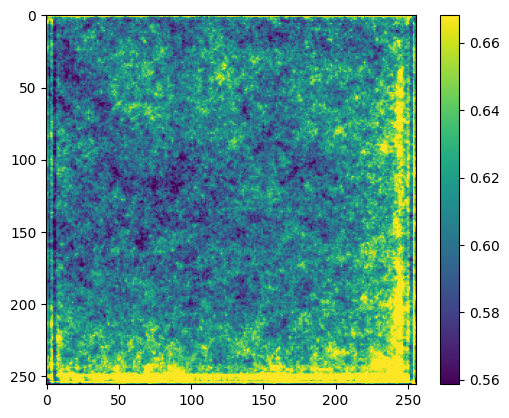

In [22]:
scale = True

for place, place_df in df.groupby("place"):
    if "HS_Davos_20170316_2m_epsg2056" not in place: 
        continue
    
    print(place)
    place_df.to_csv("tmp_df.csv")
    cid = CustomImageDataset("tmp_df.csv", index_vars = index_vars)
    
    max_col_off = place_df['row_off'].max() + size
    max_row_off = place_df['col_off'].max() + size

    mapping = torch.zeros((max_col_off, max_row_off))
    counter = torch.zeros((max_col_off, max_row_off))
    errors = torch.zeros((256, 256))
    error_counter = torch.zeros((256, 256))
    for index, name in tqdm(cid.img_labels['filename'].items(), total=len(place_df)): 
        with torch.no_grad():
            inputfile, mask, output = [torch.from_numpy(c) for c in cid[index]]
            if scale:
                inputfile[-1] = torch.ones((1, 256, 256))*0.5

            inputfile, output = inputfile.to("cuda"), output.to("cuda")
            mask = mask.squeeze().squeeze()

            hs_map = inputfile.squeeze()[-1].to("cpu")
            pred = trainer.model(inputfile.unsqueeze(0)).squeeze().squeeze()

        row_off = place_df['row_off'].iloc[index]
        col_off = place_df['col_off'].iloc[index]

        mapping[row_off:row_off+size, col_off:col_off+size] += pred.to("cpu")
        counter[row_off:row_off+size, col_off:col_off+size] += mask
        diff = abs(pred - output.squeeze().squeeze()).to("cpu")
        errors += np.multiply(diff, mask)
        error_counter += mask

    errors = np.where(error_counter != 0, np.divide(errors, error_counter + 1e-10), 0)
    print(errors.mean())

    outpath = f"/home/abetatos/Escritorio/TFM_Dataset/5.Preds/{modeltype}_{pred_model}/{place}/"
    os.makedirs(outpath, exist_ok=True)
    with open(f"{outpath}HS_pred05.pickle", "wb") as src: 
        norm_mapping = np.where(counter != 0, np.divide(mapping, counter + 1e-10), -9999.)
        pkl.dump(norm_mapping, src)

    plt.imshow(errors, cmap="viridis", vmax=errors.mean() + errors.std()*2, vmin=errors.mean() - errors.std()*2)
    plt.colorbar()
    plt.show()